# Fitting a two dimensional cross spectrum

This notebook covers how to fit a two-dimensional cross spectrum as a function of both Fourier frequency and energy. In nDspec, two-dimensional datasets like cross spectra are handled like individual datasets, and the conversion from a full cross spectrum to a given spectral-timing products (like a lag energy spectrum in a given frequency range) is handled internally. For least-chi squares fitting, nDspec makes use of the [lmfit library](https://lmfit.github.io/lmfit-py/). For error estimation, we encourage users to use Bayesian sampling, as detailed in the tutorial on [fitting power spectra](https://ndspec.readthedocs.io/en/latest/fit_psd.html). Users should never use the error estimates from `lmfit` in scientific publications, as they are highly unreliable for the complex parameter spaces that are common in X-ray spectral and spectral-timing models.

In [1]:
import os
import sys
import numpy as np

sys.path.append('/home/matteo/Software/nDspec/src/')
from ndspec.Response import ResponseMatrix
import ndspec.FitCrossSpectrum as fitcross
import ndspec.models as models
from ndspec.SimpleFit import load_lc

## Converting lightcurves into lags

Due to some subtleties in energy calibration, nDspec currently only supports using Stingray `EventList` objects as input data for frequency dependent products. In this notebook, we are interested in energy-dependent data, so we will derive our data products from raw lightcurves produced with `HEASOFT` instead. 

First, we are going to define 41 geometrically spaced energy bin edges (meaning our data will use 40 energy channels), and then (due to how the lightcurve files themselves have been named) shift the edges of each bin such that it aligns with the binning in the NICER response matrix.

In [2]:
#load and rebin response - we need this to have the exact intervals for our energy bins
path = "/home/matteo/Data/J1820/EventFiles/"

rmfpath = path+"1200120106_rmf.pha"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = path+"1200120106_arf.pha"
nicer_matrix.load_arf(arfpath)

rebin_bounds = np.geomspace(0.5,10,41)
rebin_bounds = np.append(np.min(nicer_matrix.emin),rebin_bounds)
rebin_bounds = np.append(rebin_bounds,np.max(nicer_matrix.emax))

rebin_bounds_lo = rebin_bounds[:-1]
rebin_bounds_hi = rebin_bounds[1:]
rebin_response = nicer_matrix.rebin_channels(rebin_bounds_lo,rebin_bounds_hi)

channel_grid = 0.5*(rebin_response.emax+rebin_response.emin)
channel_width = rebin_response.emax-rebin_response.emin
#finally, find the array of energy channel edges that line up with the response and are roughly geometrically spaced
fine_channel_grid_edges = np.append(channel_grid-0.5*channel_width,channel_grid[-1]+0.5*channel_width[-1])

Arf missing, please load it
Arf loaded


Using [Stingray](https://docs.stingray.science/en/stable/), we will createa a function which takes the path to our lightcurves (stored as strings), the Fourier frequency interval where we want to compute the lags, the time resolution of the lightcurves, and the segment size over which we wish to average. From this, our function will calculate and return the lag-energy spectrum and its error.

In [3]:
from ndspec.SimpleFit import load_lc
from stingray.fourier import avg_cs_from_timeseries, avg_pds_from_timeseries
from stingray.fourier import poisson_level
from stingray.fourier import error_on_averaged_cross_spectrum
from stingray.utils import show_progress

def lag_from_lcs(lc_strings,lc_ref,freq_lo,freq_hi,seg_size,time_res):
    time_ref,counts_ref,gtis_ref = load_lc(lc_ref)
    results = avg_pds_from_timeseries(
            time_ref,
            gtis_ref, 
            seg_size,
            time_res,
            silent=True,
            norm="none",
            fluxes=counts_ref,
        )
    freq = results["freq"]
    ref_power = results["power"]
    m_ave = results.meta["m"]
    ref_power_noise = poisson_level(norm="none", n_ph=np.sum(counts_ref) / m_ave)
    freq_mask = (freq>freq_lo) & (freq<freq_hi)
    n_freqs = freq_mask[freq_mask==True].size
    mean_ref_power = np.mean(ref_power[freq_mask])
    m_tot = n_freqs * m_ave    
    f_mean = (freq_lo + freq_hi)*0.5
    
    lag_spec = []
    lag_spec_err = []
    
    for i in range(len(lc_strings)):
        time_sub,counts_sub,gtis_sub = load_lc(lc_strings[i])

        results_cross = avg_cs_from_timeseries(
                time_sub,
                time_ref,
                gtis_sub,
                seg_size,
                time_res,
                silent=True,
                norm="none",
                fluxes1=counts_sub,
                fluxes2=counts_ref,
            )
        
        results_ps = avg_pds_from_timeseries(
                time_sub,
                gtis_sub, 
                seg_size,
                time_res,
                silent=True,
                norm="none",
                fluxes=counts_sub,
            )

        sub_power_noise = poisson_level(
            norm="none", n_ph=np.sum(counts_sub) / results_ps.meta["m"]
        )
        cross = results_cross["power"]
        sub_power = results_ps["power"]
        Cmean = np.mean(cross[freq_mask])
        mean_sub_power = np.mean(sub_power[freq_mask])

        _, _, phi_e, _ = error_on_averaged_cross_spectrum(
                Cmean,
                mean_sub_power,
                mean_ref_power,
                m_tot,
                sub_power_noise,
                ref_power_noise,
                common_ref=True,
            )

        phase = np.angle(Cmean) 
        lag_spec = np.append(lag_spec,phase/(2*np.pi*f_mean))
        lag_spec_err = np.append(lag_spec_err,phi_e/(2*np.pi*f_mean))
    
    return lag_spec, lag_spec_err

We now need to define the paths to our lightcurve fits files, together with the Fourier frequency grid, time resolution, reference band, and segment size used to average the data. Afterwards, we can load all of the lag-energy spectra and their error by looping over all frequencies. We will store the data and errors in one-dimensional arrays, in order to ensure compatibility with [lmfit](https://lmfit.github.io/lmfit-py/).

In this example, because we have picked a fairly fine energy channel resolution (40 channels), we will use only 6 bins in Fourier frequency, from 0.2 to 16 Hz. 

In [4]:
#round the bins of the channels in each lightcurve
fine_channel_string = []
for i in range(len(fine_channel_grid_edges)):
    bin = "%.0f" % round(100.*fine_channel_grid_edges[i],2)
    fine_channel_string = np.append(fine_channel_string,bin)
fine_channel_string = np.array(fine_channel_string,dtype=int)

#create the path to each lightcurve
fine_full_string = []
for i in range(len(fine_channel_string)-1):
    bin_string = "_"+str(fine_channel_string[i])+"-"+str(fine_channel_string[i+1]-1)
    lc_string = "/home/matteo/Software/nDspec/FitsFiles/LCs/FineRes/ni1200120106mpu7_sr" + bin_string + ".lc"
    fine_full_string = np.append(fine_full_string,lc_string)

ref_path = "/home/matteo/Software/nDspec/FitsFiles/LCs/ni1200120106mpu7_sr_reference.lc"

#define the frequency bounds and, time resolution, reference band  and segment size, and load the data
freqs = np.geomspace(0.2,16,7)

lags = []
lags_err = []

dt = 0.03
segment_size = 5
ref_band = [0.5, 10]

for i in show_progress(range(6)):    
    lag,lag_err=lag_from_lcs(fine_full_string,ref_path,freqs[i],freqs[i+1],segment_size,dt)
    lags = np.append(lags,lag)
    lags_err = np.append(lags_err,lag_err)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.31s/it]


## Setting up a two-dimensional fit

Now that the lag spectra and their errors are stored in the `lags` and `lags_err` arrays, we want to initialize a `FitCrossSpectrum` object and pass to it all the information required to set up a fit of multiple lag-energy spectra correctly.

First, we need to use the `set_coordinates` method to specify that we are fitting Fourier lags. Secondly, we need to use the `set_product_dependence` to specify that we are fitting energy-dependent quantities. Having done this, we can load the data with the `set_data` method. Because two-dimensional cross spectra are complex datasets, we need to provide additional information to load the data and set up model calcuations correctly. In particular, we also must supply:
- the instrument response, as a `ResponseMatrix` object
- the reference band used to calculate the lags, passing an array with its lower and upper energy bounds
- the grid of energy channel edges used to calculate the lags, as a numpy array
- the actual data and its error bars, formatted as a one-dimensional array as above
- the bins of Fourier frequencies over which we calculated the lags, as described in [Uttley et al. 2014](https://ui.adsabs.harvard.edu/abs/2014A%26ARv..22...72U/abstract)
- the time resolution and lightcurve segment sizes used to calculate the lags, as floating point numbers

In [5]:
lags_fit = fitcross.FitCrossSpectrum()
lags_fit.set_coordinates("lags")
lags_fit.set_product_dependence("energy")

lags_fit.set_data(nicer_matrix,ref_band,fine_channel_grid_edges,
                  lags,lags_err,
                  freq_bins=freqs,
                  time_res=dt,seg_size=segment_size)

Once we have loaded the data, we can refine the energy and frequency ranges we are interested in fitting using the `ignore_energies`, `notice_energies`, `ignore_frequencies` and `notice_frequencies` methods, and then plot the data to make sure it has been loaded/set up correctly.

Having done all this, we can plot the data with the `plot_data_1d` and `plot_data_2d` methods to ensure it has been loaded corectly.

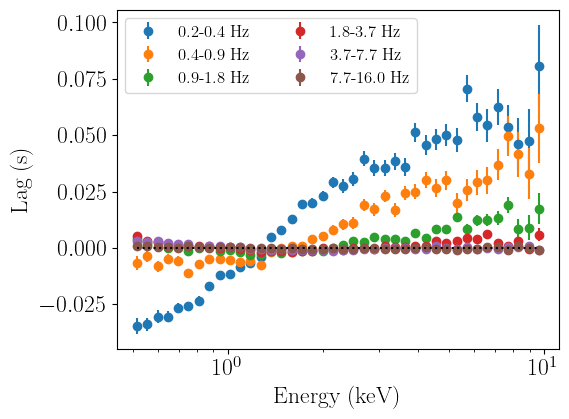

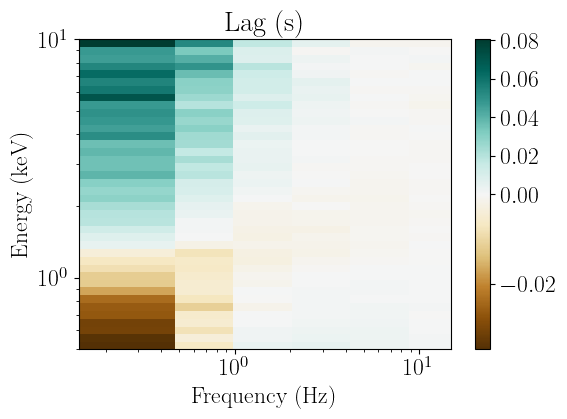

In [6]:
lags_fit.ignore_energies(0,0.5)
lags_fit.ignore_energies(10.0,fine_channel_grid_edges[-1])
lags_fit.plot_data_1d()
lags_fit.plot_data_2d()

## Fitting a two-d model with components defined in both time and Fourier domains

We will now fit our lags with a phenomenological model combining a variable corona (characterized by a pivoting powerlaw, e.g. [Mastroserio et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488..348M/abstract)) and a phenomenological model for disk irradiation. The general idea is that the hard lags are due to the variability from the corona, while the soft lags are due to some form of reprocessing in the disk (which may or may not include light travel delays). The implementation in this notebook is purely phenomenological, so one can think of this model as a time-dependent equivalent of the standard "disk+powerlaw" model used in phenomenological spectral fits.

The parameters for the pivoting power-law model are:
- `norm_pl`: the normalization of the (variable) power-law
- `pl_index`: the photon index of the powerlaw
- `gamma_0`: the gamma parameter in Mastroserio et al. 2019; it represents the fractional variability of the power-law photon index, with respect to the power-law normalization. For instance, `gamma_0`=0.25 means that if the fractional rms in the normalization is 10%, that in the photon index is 2.5% at a frequency `nu_0` (see below)
- `gamma_slope`: sets the frequency dependence of the power-law photon index variability. For each Fourier frequency, the photon index fractional rms is defined as `gamma(nu)= gamma_0+log10(nu/nu_0)*gamma_slope`
- `phi_0`: the `phiAB` parameter in Mastroserio et all. 2019; it controls the phase between changes in the normalization and photon index of the powerlaw. Positive `phi_0` produces soft lags, negative `phi_0` produces hard lags. This phase is defined at `nu_0` (see below).
- `phi_slope`: sets the frequency dependence of the phase between normalization and photon index variation. For each Fourier frequency, the phase is defined as `phi(nu)= phi_0+log10(nu/nu_0)*phi_slope`
- `nu_0`: the Fourier frequency used to define `gamma_0` and `phi_0`
- `cutoff`: a low energy cutoff in the power-law, used to mimick the low energy turnover of Thermal Comptonization spectra

The parameters for the irradiated disk model are:
- `rev_norm`: the normalization of the impulse response
- `rev_temp`: the initial temperature of the black body representing the irradiated disk
- `rise_slope`, `decay_slope`: the slopes of the broken power-law controlling the time rise and decay of the impulse response
- `peak_time`: the time scale at which the impulse switches from rising to decaying time depdence
- `temp_slope`: the slope controlling the temperature change of the black body over time. The temperature time dependence is `T(t)=rev_temp*t^temp_slope`

The tricky part of combining the pivoting powerlaw and irradiated disk components is that the former is easily defined directly in Fourier space, while the latter is in the form of an impulse response function defined in the time domain. This means that before combining the two components, we need to convert our irradiated disk impulse response function into the Fourier domain, by converting it into a transfer function. nDspec provides at tool to this thruogh the `CrossSpectrum` class method `transfer_from_irf`, so we can simply instatiate an object in the model call and return the transfer function after calculating it through the class instance. For more information on using the `CrossSpectrum` class we refer users to the [two](https://ndspec.readthedocs.io/en/latest/timing.html) [notebooks](https://ndspec.readthedocs.io/en/latest/numerics.html) on how nDspec handles spectral timing products. These notebooks also illustrated the behavior of the model components used in this fit.

Finally, models defined from transfer/impulse response function also require assuming an underlying power spectrum to calculate a cross spectrum and its derived products. Here, we will assume that the underlying power spectrum that is driving the variability is similar to the one observed in the data (which is modelled in the [tutorial on power spectra](https://ndspec.readthedocs.io/en/latest/fit_psd.html)): a sum of three broad Lorentzian components.

In [7]:
from scipy.interpolate import interp1d
from ndspec.Timing import PowerSpectrum, CrossSpectrum
from xspec import *
Xset.chatter = 0

#wrap PyXspec for tbabs
def wrap_tbabs(energs,nH):
    model = Model("tbabs*po")
    model.TBabs.nH = nH
    model.powerlaw.PhoIndex = 0.0
    model.powerlaw.norm = 1.0
    Plot("model")
    tbabs_x = np.array(Plot.x())
    tbabs_y = np.array(Plot.model())
    interp_obj = interp1d(tbabs_x,tbabs_y,fill_value='extrapolate')   
    model = interp_obj(energs) 
    return model

#this is defined in the Fourier domain as a transfer function
def pivoting_lowecut(energs,freqs,norm_pl,pl_index,gamma_0,gamma_slope,phi_0,phi_slope,nu_0,cutoff):
    param_array = np.array([norm_pl,pl_index,gamma_0,gamma_slope,phi_0,phi_slope,nu_0])
    model = np.transpose(models.pivoting_pl(freqs,energs,param_array))*np.exp(-cutoff/energs)
    return model

#the reverberation models are defined in the time domain, so we need to define a cross spectrum to 
#convert it to a transfer function to then return
def reverb(energs,times,rev_norm,rev_temp,rise_slope,decay_slope,peak_time,temp_slope):
    param_array = np.array([rev_norm,rev_temp,rise_slope,decay_slope,peak_time,temp_slope])
    impulse_response = models.bbody_bkn(times,energs,param_array)
    cross_spec = CrossSpectrum(times,energ=energs)
    cross_spec.set_impulse(impulse_response)
    cross_spec.transfer_from_irf()
    model = np.transpose(cross_spec.trans_func)
    return model

psd = PowerSpectrum(lags_fit._times)
#set Lorentzian parameters from the PSD fit 
l1_pars = np.array([0.06,0.33,0.25])
l2_pars = np.array([0.78,0.08,0.16])
l3_pars = np.array([2.45,0.32,0.12])
psd_model = models.lorentz(psd.freqs,l1_pars)+models.lorentz(psd.freqs,l2_pars)+models.lorentz(psd.freqs,l3_pars)
psd.power_spec = psd_model

Now that we have defind the model functions, we can instatiate our model as a lmfit `Model` object, and its parameters as an lmfit `Parameters` object (returned through the `make_params` method of lmfit `Model` objects). This synthax is essentially identical to that of other X-ray fitting packages: model = absorption*(pivoting + disk irradiation). However, we also must specificy the independent variables `energs` and `freqs` (energy and Fourier frequency) for the pivoting powerlaw transfer function model, and `energs` and `times` (energies and times) for the reverberation impulse response function model. The conversion between the correct time and frequency grids is handled internally by the nDspec `FitCrossSpectrum` object. 

We then pass the model to the fitter with the `set_model` object. When doing so, we must also specify that the output of our model is a transfer function in order to let our `FitCrossSpectrum` object know what operations must be performed on the model to convert it to the same units as the data (lag-energy spectra in this case). Finally, we also set the assumed underlying power spectrum with the `set_psd_weights` method, and the model parameters with the `set_params` method. 

In [8]:
from lmfit import Model as LM_Model

timing_model = LM_Model(wrap_tbabs)*(LM_Model(pivoting_lowecut,independent_vars=['energs','freqs'])+
                                     LM_Model(reverb,independent_vars=['energs','times']))

start_params = timing_model.make_params(nH=dict(value=0.09,min=0.08,max=0.2,vary=True),
                                        norm_pl=dict(value=1,min=1e-3,max=1e4,vary=False),
                                        pl_index=dict(value=-1.59,min=-1.8,max=-1.4,vary=True),
                                        gamma_0=dict(value=0.046,min=0,max=0.5,vary=True),
                                        gamma_slope=dict(value=-0.016,min=-0.1,max=0,vary=True),
                                        phi_0=dict(value=-2.31,min=-np.pi,max=np.pi,vary=True),
                                        phi_slope=dict(value=2.01,min=-3.,max=3.0,vary=True),
                                        nu_0=dict(value=lags_fit.freq_bounds[0],min=0.0001,max=10,vary=False),
                                        cutoff=dict(value=0.20,min=0.01,max=0.8,vary=True,expr='rev_temp'),
                                        rev_norm=dict(value=8.55,min=0,max=1e4,vary=True),
                                        rev_temp=dict(value=0.20,min=0.01,max=0.8,vary=True),
                                        rise_slope=dict(value=3,min=0,max=10,vary=False),
                                        decay_slope=dict(value=-1.46,min=-10,max=0,vary=True),
                                        peak_time=dict(value=0.006,min=0.0,max=0.2,vary=True),
                                        temp_slope=dict(value=-0.4,min=-3,max=0,vary=True),
                                        ) 


lags_fit.set_model(timing_model,model_type="transfer")
lags_fit.set_psd_weights(psd)
lags_fit.set_params(start_params)

 - Adding parameter "nH"
 - Adding parameter "norm_pl"
 - Adding parameter "pl_index"
 - Adding parameter "gamma_0"
 - Adding parameter "gamma_slope"
 - Adding parameter "phi_0"
 - Adding parameter "phi_slope"
 - Adding parameter "nu_0"
 - Adding parameter "cutoff"
 - Adding parameter "rev_norm"
 - Adding parameter "rev_temp"
 - Adding parameter "rise_slope"
 - Adding parameter "decay_slope"
 - Adding parameter "peak_time"
 - Adding parameter "temp_slope"


Once data, model and parameters are loaded, we can plot them against each other with the `plot_model_1d` and `plot_model_2d` methods. In the latter case, it is also possible to renormalize the data from time lag amplitude to phase using the `use_phase` argument, which can make two-dimensional colormaps easier to read.  

Finally, users can check the fit statistic for the current set of parameters, and their values and bounds, with the `print_fit_stat` and `model_params.pretty_print` methods.

In this case, the starting parameters seem fairly close to a decent fit, so after checking the plots and the fit statistic, we can run a fit with the `fit_data` method and plot the results.

/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2
/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.
/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2
/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.


Goodness of fit metrics:
Chi squared             2569.898515129298
Reduced chi squared     11.222264258206541
Data bins:              240
Free parameters:        11
Degrees of freedom:     229
Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
cutoff            0.2     0.01      0.8     None    False rev_temp     None
decay_slope     -1.46      -10        0     None     True     None     None
gamma_0         0.046        0      0.5     None     True     None     None
gamma_slope    -0.016     -0.1        0     None     True     None     None
nH               0.09     0.08      0.2     None     True     None     None
norm_pl             1    0.001    1e+04     None    False     None     None
nu_0              0.2   0.0001       10     None    False     None     None
peak_time       0.006        0      0.2     None     True     None     None
phi_0           -2.31   -3.142    3.142     None     True     None     None
phi_slope        2.01       -3        3     N

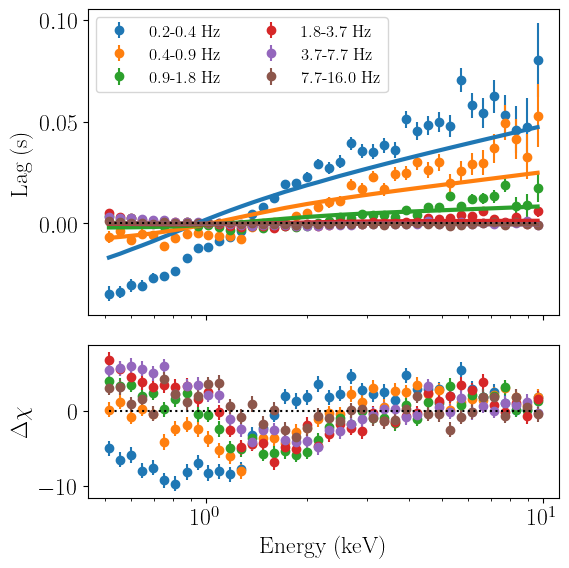

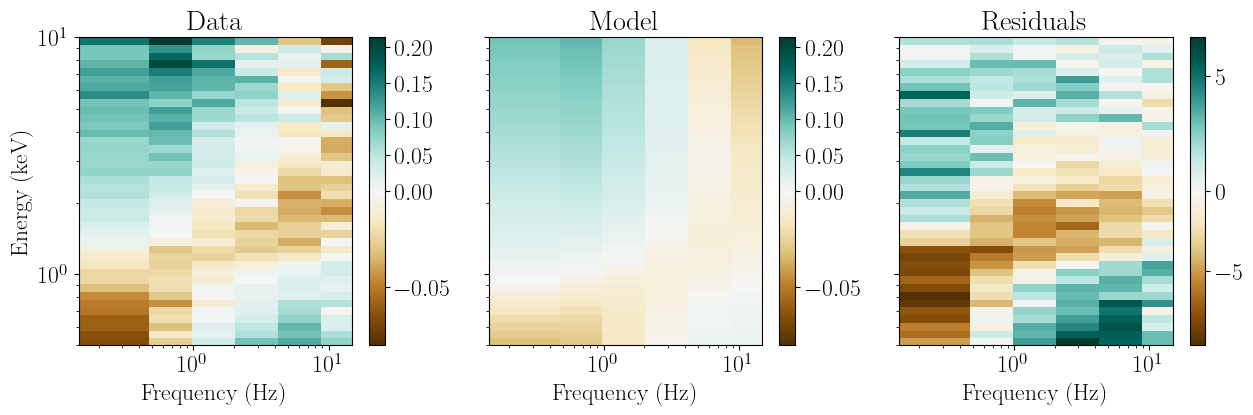

In [9]:
lags_fit.plot_model_1d()
lags_fit.plot_model_2d(use_phase=True)
lags_fit.print_fit_stat()
lags_fit.model_params.pretty_print()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 399
    # data points      = 240
    # variables        = 11
    chi-square         = 639.706660
    reduced chi-square = 2.79347887
    Akaike info crit   = 257.288993
    Bayesian info crit = 295.576021
[[Variables]]
    nH:           0.19999980 +/- 0.06562941 (32.81%) (init = 0.09)
    norm_pl:      1 (fixed)
    pl_index:    -1.74256491 +/- 0.21707557 (12.46%) (init = -1.59)
    gamma_0:      0.06243505 +/- 0.00755168 (12.10%) (init = 0.046)
    gamma_slope: -0.02018599 +/- 0.00646729 (32.04%) (init = -0.016)
    phi_0:       -2.11100943 +/- 0.19452217 (9.21%) (init = -2.31)
    phi_slope:    2.06243972 +/- 0.22416770 (10.87%) (init = 2.01)
    nu_0:         0.2 (fixed)
    cutoff:       0.31863633 +/- 0.03412447 (10.71%) == 'rev_temp'
    rev_norm:     16.5907433 +/- 1361.84591 (8208.47%) (init = 8.55)
    rev_temp:     0.31863633 +/- 0.03412447 (10.71%) (init = 0.2)
    rise_slope:   3 (fixed)
    decay_

/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2
/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.


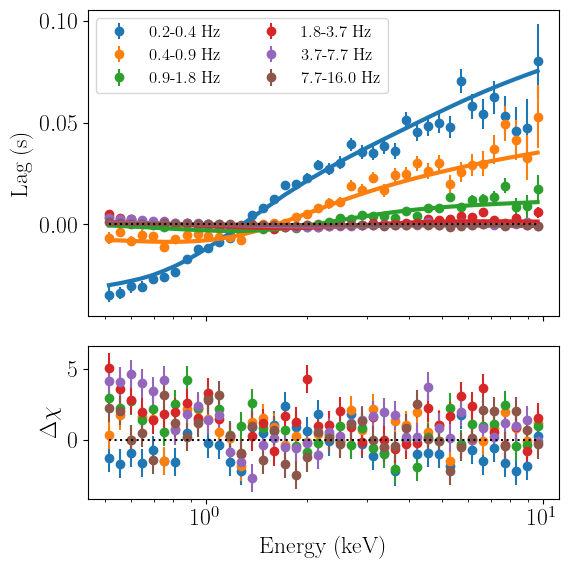

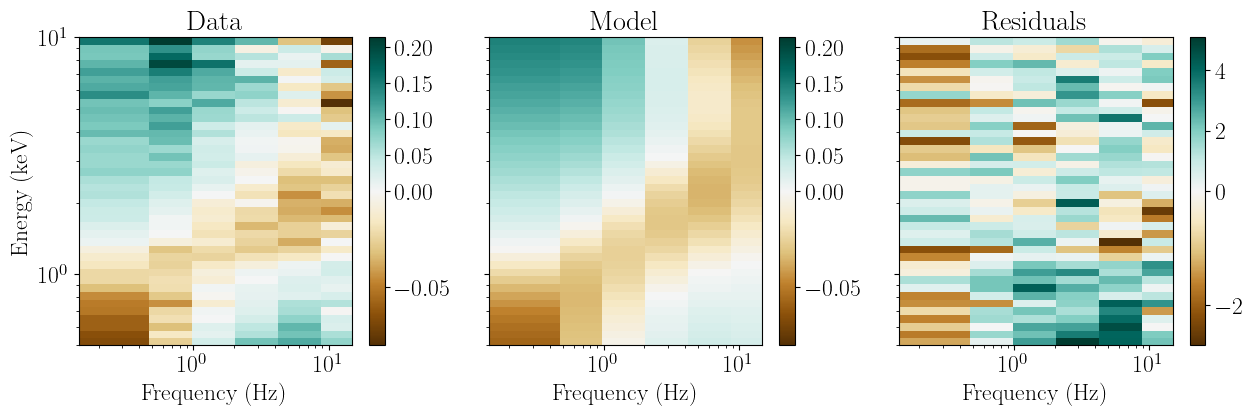

In [10]:
lags_fit.fit_data()
lags_fit.plot_model_1d()
lags_fit.plot_model_2d(use_phase=True)

It looks like our model can fit the lag data reasonably well, but there are very noticeable residuals, paritcularly in the soft X-rays. One reason for why energy-dependent residuals might appear when fitting a cross spectrum is due to imperfections in the instrument calibration: photon energies are never reconstructed perfectly, and as a result the reference band will contain some events outside of its nominal energy range, and will lack some events within that nominal range. In practice, this manifests as the introduction of a small phase, which may or may not be frequency dependent (see appendix E in [Mastroserio et al. 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.475.4027M/abstract) for more information) but which needs to be accounted for. 

In nDspec, it is possible to account phenomenologically for these small phase offsets. We can do this by calling the `renorm_phases` method, and passing a `True` input. When this happens, the fitter object will include an additional small phase offset, which is free to vary independently around 0 in each Fourier frequency bin. We can check that this is the case by printing the fit statistics (as one would expect, the reduced chi squared increases, due to the increase in free parameters) and the list of parameters.

After allowing the fitter object to renormalize phases, we can run the same fit again and check the result:

In [11]:
no_renorm_params = lags_fit.model_params
lags_fit.renorm_phases(True)
lags_fit.print_fit_stat()
lags_fit.model_params.pretty_print()

Goodness of fit metrics:
Chi squared             639.7066601867023
Reduced chi squared     2.868639731778934
Data bins:              240
Free parameters:        17
Degrees of freedom:     223
Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
cutoff            0.3186     0.01      0.8  0.03412    False rev_temp     None
decay_slope       -1.494      -10        0   0.1259     True     None     None
gamma_0          0.06244        0      0.5 0.007552     True     None     None
gamma_slope     -0.02019     -0.1        0 0.006467     True     None     None
nH                   0.2     0.08      0.2  0.06563     True     None     None
norm_pl                1    0.001    1e+04        0    False     None     None
nu_0                 0.2   0.0001       10        0    False     None     None
peak_time        0.00951        0      0.2   0.5223     True     None     None
phase_renorm_1         0    -0.05     0.05     None     True     None     None
phase_renorm_2  

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 323
    # data points      = 240
    # variables        = 17
    chi-square         = 383.142412
    reduced chi-square = 1.71812741
    Akaike info crit   = 146.264279
    Bayesian info crit = 205.435141
##  Warning: uncertainties could not be estimated:
    pl_index:        at boundary
[[Variables]]
    nH:              0.08000137 (init = 0.1999998)
    norm_pl:         1 (fixed)
    pl_index:       -1.40000557 (init = -1.742565)
    gamma_0:         0.04285010 (init = 0.06243505)
    gamma_slope:    -9.1827e-04 (init = -0.02018599)
    phi_0:          -1.72167850 (init = -2.111009)
    phi_slope:       2.24370594 (init = 2.06244)
    nu_0:            0.2 (fixed)
    cutoff:          0.33568104 == 'rev_temp'
    rev_norm:        36.6975525 (init = 16.59074)
    rev_temp:        0.33568104 (init = 0.3186363)
    rise_slope:      3 (fixed)
    decay_slope:    -1.76392841 (init = -1.493975)
    peak_time:      

/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2
/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.


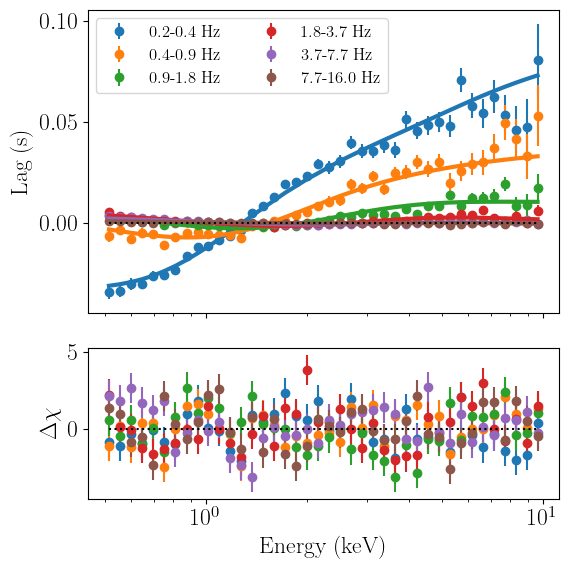

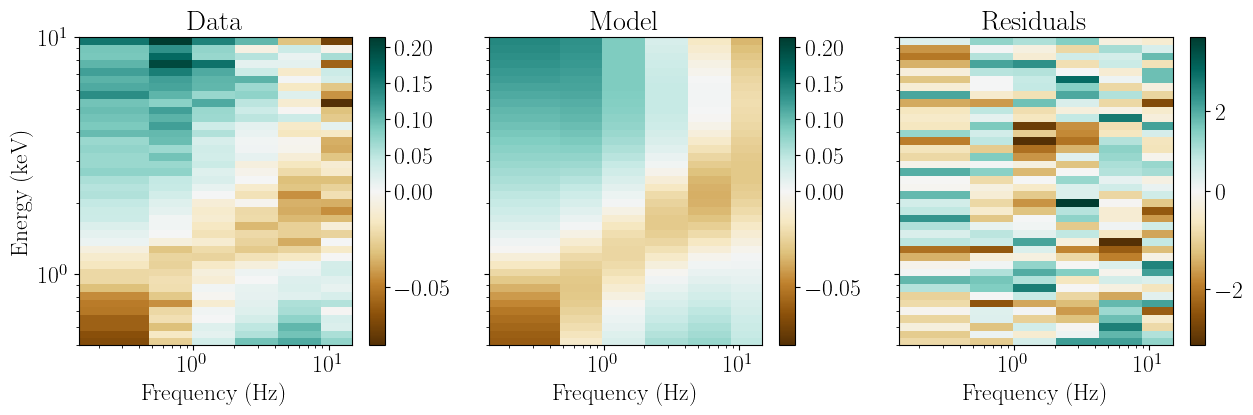

In [12]:
lags_fit.fit_data()
lags_fit.plot_model_1d()
lags_fit.plot_model_2d(use_phase=True)

We see that the best-fitting parameters are reasonably similar to our starting point, but the structure in the residuals (for example, in the soft X-rays) has mostly disappeared, and the residuals appear reasonable. Therefore, our pivoting+irradiated disk model now fits the lags reasonably well.

## From lag spectra to fitting modulus and phase 

Finally, we want to move beyond fitting just lags, and instead model the full energy and frequency dependent cross spectrum - both its modulus and phase. In nDspec this is essentially analogous to fitting lags alone. We begin by converting all our lightcurves into arrays of modulus/phase and its errors, identically to how we built the lag spectra.

In [13]:
from stingray.fourier import get_average_ctrate

def phase_from_lcs(lc_strings,lc_ref,freq_lo,freq_hi,seg_size,timeres):
    time_ref,counts_ref,gtis_ref = load_lc(lc_ref)
    results = avg_pds_from_timeseries(
            time_ref,
            gtis_ref, 
            seg_size,
            timeres,
            silent=True,
            norm="none",
            fluxes=counts_ref,
        )
    freq = results["freq"]
    ref_power = results["power"]
    m_ave = results.meta["m"]
    ref_power_noise = poisson_level(norm="none", n_ph=np.sum(counts_ref) / m_ave)
    freq_mask = (freq>freq_lo) & (freq<freq_hi)
    n_freqs = freq_mask[freq_mask==True].size
    mean_ref_power = np.mean(ref_power[freq_mask])
    m_tot = n_freqs * m_ave
    
    phase_spec = []
    phase_spec_err = []
    
    for i in range(len(lc_strings)):
        time_sub,counts_sub,gtis_sub = load_lc(lc_strings[i])
        results_cross = avg_cs_from_timeseries(
                time_sub,
                time_ref,
                gtis_sub,
                seg_size,
                timeres,
                silent=True,
                norm="none",
                fluxes1=counts_sub,
                fluxes2=counts_ref,
            )        
        results_ps = avg_pds_from_timeseries(
                time_sub,
                gtis_sub, 
                seg_size,
                timeres,
                silent=True,
                norm="none",
                fluxes=counts_sub,
            )
        sub_power_noise = poisson_level(
            norm="none", n_ph=np.sum(counts_sub) / results_ps.meta["m"]
        )
        cross = results_cross["power"]
        sub_power = results_ps["power"]
        Cmean = np.mean(cross[freq_mask])
        mean_sub_power = np.mean(sub_power[freq_mask])

        _, _, phi_e, _ = error_on_averaged_cross_spectrum(
                Cmean,
                mean_sub_power,
                mean_ref_power,
                m_tot,
                sub_power_noise,
                ref_power_noise,
                common_ref=True,
            )

        phase = np.angle(Cmean) 
        phase_spec = np.append(phase_spec,phase)
        phase_spec_err = np.append(phase_spec_err,phi_e)
    
    return phase_spec, phase_spec_err

def modulus_from_lcs(lc_strings,lc_ref,freq_lo,freq_hi,seg_size,timeres,norm="abs"):
    time_ref,counts_ref,gtis_ref = load_lc(lc_ref)
    results = avg_pds_from_timeseries(
            time_ref,
            gtis_ref, 
            seg_size,
            timeres,
            silent=True,
            norm="abs",
            fluxes=counts_ref*timeres,
        )

    freq = results["freq"]
    ref_power = results["power"]
    m_ave = results.meta["m"]
    countrate_ref = get_average_ctrate(time_ref, gtis_ref, seg_size, counts=counts_ref*timeres)
    ref_power_noise = poisson_level(norm="abs", meanrate=countrate_ref)
    freq_mask = (freq>freq_lo) & (freq<freq_hi)
    n_freqs = freq_mask[freq_mask==True].size
    mean_ref_power = np.mean(ref_power[freq_mask])
    m_tot = n_freqs * m_ave
    delta_nu = n_freqs / seg_size
    
    f_mean = (freq_lo + freq_hi)*0.5
    
    mod_spec = []
    mod_spec_err = []
    
    for i in range(len(lc_strings)):
        time_sub,counts_sub,gtis_sub = load_lc(lc_strings[i])
        results_cross = avg_cs_from_timeseries(
                time_sub,
                time_ref,
                gtis_sub,
                seg_size,
                timeres,
                silent=True,
                norm="abs",
                fluxes1=counts_sub*timeres,
                fluxes2=counts_ref*timeres,
            )
        
        results_ps = avg_pds_from_timeseries(
                time_sub,
                gtis_sub, 
                seg_size,
                timeres,
                silent=True,
                norm="abs",
                fluxes=counts_sub*timeres,
            )
        countrate_sub = get_average_ctrate(time_sub, gtis_sub, seg_size, counts=counts_sub*timeres)
        sub_power_noise = poisson_level(norm="abs", meanrate=countrate_sub)
        cross = results_cross["power"]
        sub_power = results_ps["power"]
        Cmean = np.mean(cross[freq_mask])
        mean_sub_power = np.mean(sub_power[freq_mask])
        
        _, _, _, mod_e = error_on_averaged_cross_spectrum(
                Cmean,
                mean_sub_power,
                mean_ref_power,
                m_tot,
                sub_power_noise,
                ref_power_noise,
                common_ref=True,
            )
        modulus = np.abs(Cmean) 

        if norm == "frac":
            modulus, mod_e = modulus / countrate_sub, mod_e / countrate_sub
        
        mod_spec = np.append(mod_spec,modulus)
        mod_spec_err = np.append(mod_spec_err,mod_e)
    
    return mod_spec, mod_spec_err

phases = []
phases_err = []
mods = []
mods_err = []
   
norm_data="abs"

for i in show_progress(range(6)):
    phi,phi_err=phase_from_lcs(fine_full_string,ref_path,freqs[i],freqs[i+1],segment_size,dt)
    phases = np.append(phases,phi)
    phases_err=np.append(phases_err,phi_err)
    
    mod,mod_err=modulus_from_lcs(fine_full_string,ref_path,freqs[i],freqs[i+1],segment_size,dt)
    mods=np.append(mods,mod)
    mods_err=np.append(mods_err,mod_err)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:42<00:00,  7.13s/it]


We can now initialize a `FitCrossSpectrum` object as before, and set the coordinates to `polar` and the dependency to `energy`. The arrays passed to the `set_data` method need to be one-dimensional and equally sized, containing first all the moduli (or their errors) and then all the phases. 

In this case, we include a 0.5% systematic error in errors for the modulus. The reason for this choice is that otherwise, the smaller error bars on the modululs compared to the phase would result in the fit essentially ignoring the latter and trying to only match the former. 

Having set up the fit correctly we can plot the data to ensure that it has been loaded properly. Not that because we are using absolute-rms normalization, the shape of the modulus is heavily affected by the NICER effective area.

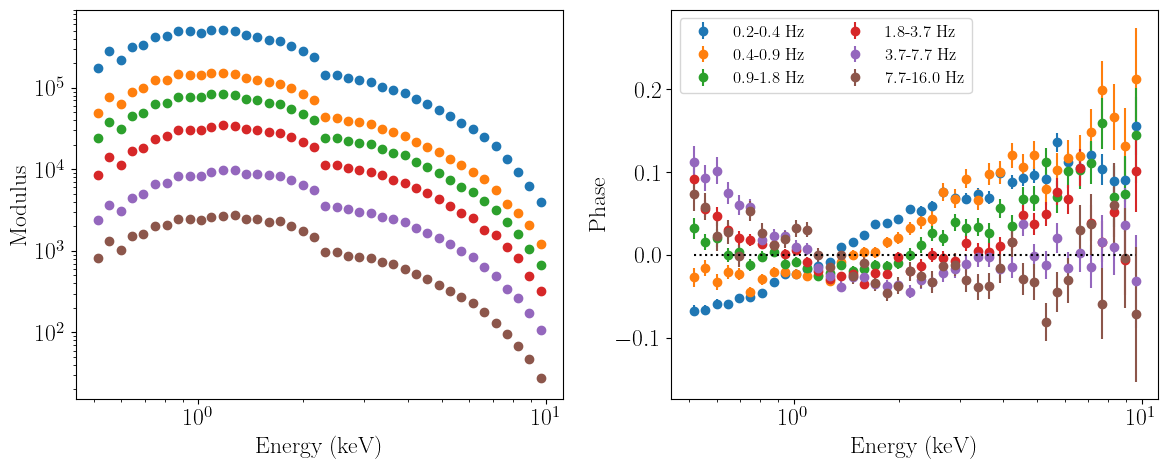

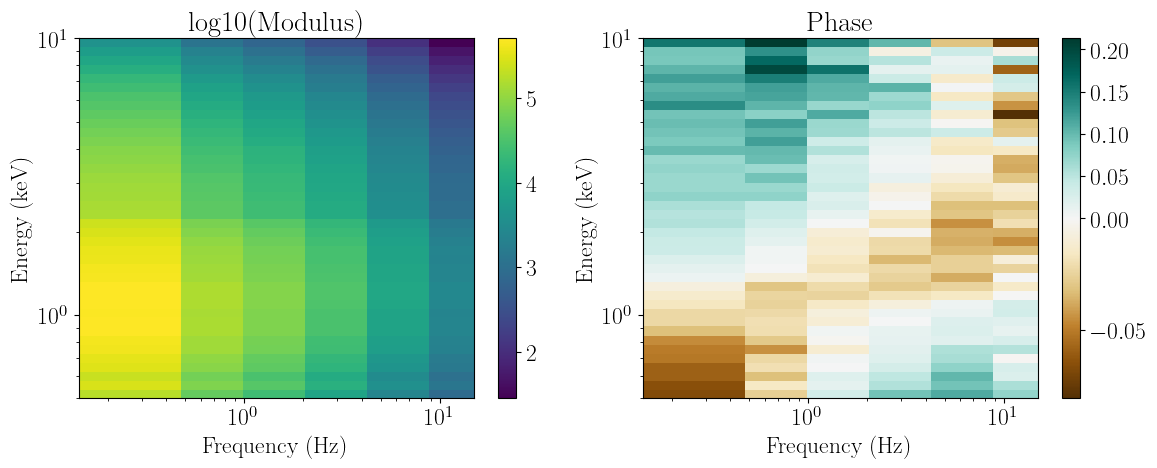

In [14]:
full_fit = fitcross.FitCrossSpectrum()
full_fit.set_coordinates("polar")
full_fit.set_product_dependence("energy")

full_data = np.append(mods,phases)
mods_err_sys = np.sqrt(mods_err**2+0.005*mods**2)
full_errs = np.append(mods_err_sys,phases_err)

#pass the data, errors, response, and time/frequency grid information identically to lags alone
full_fit.set_data(nicer_matrix,ref_band,fine_channel_grid_edges,
                  full_data,full_errs,
                  freq_bins=freqs,
                  time_res=dt,seg_size=segment_size)

full_fit.ignore_energies(0,0.5)
full_fit.ignore_energies(10.0,fine_channel_grid_edges[-1])
full_fit.plot_data_1d()
full_fit.plot_data_2d()

Setting up the model is also very similar to fitting lags alone. We will start with the parameters from the first fit of the lag spectra, in which we didn't renormalize the phases. 

The only difference in the free parameters is in the normalization of the components. If we are fitting lags, the data is not sensitive to the normalization of all the pivoting and reverberation components, but only to their ratio. As a result, we kept the power-law normalization fixed to unity. The modulus is instead sensitive to both normalizations, so we free both during the fit and set their values to something that roughly matches the data.

 - Adding parameter "nH"
 - Adding parameter "norm_pl"
 - Adding parameter "pl_index"
 - Adding parameter "gamma_0"
 - Adding parameter "gamma_slope"
 - Adding parameter "phi_0"
 - Adding parameter "phi_slope"
 - Adding parameter "nu_0"
 - Adding parameter "cutoff"
 - Adding parameter "rev_norm"
 - Adding parameter "rev_temp"
 - Adding parameter "rise_slope"
 - Adding parameter "decay_slope"
 - Adding parameter "peak_time"
 - Adding parameter "temp_slope"


/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2
/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.
/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2
/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.


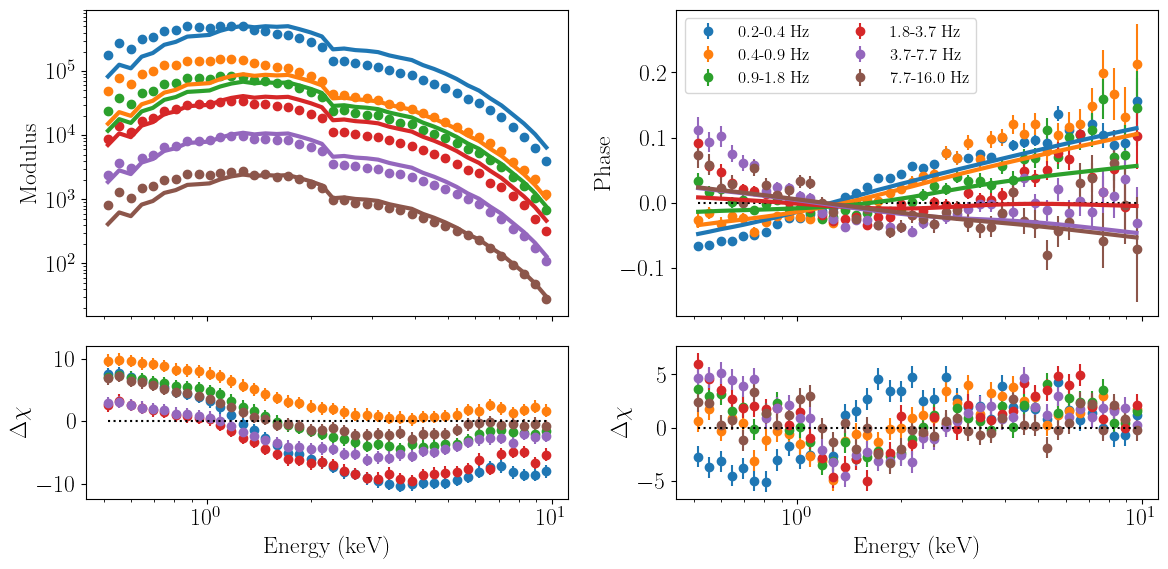

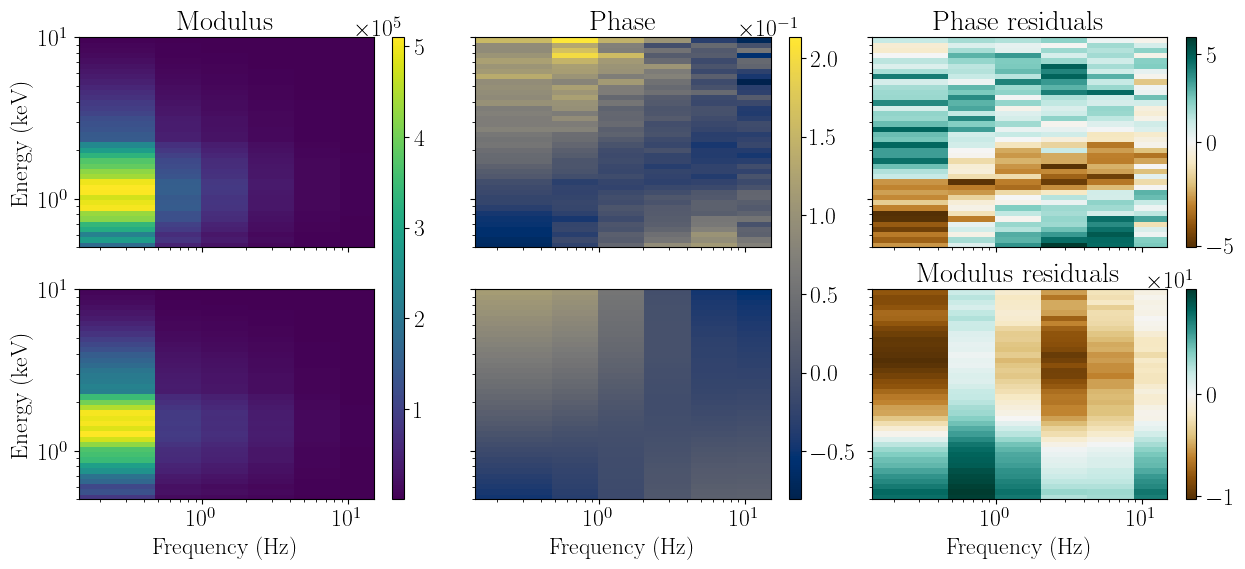

In [15]:
full_fit.set_model(timing_model,model_type="transfer")
full_fit.set_psd_weights(psd)
full_fit.set_params(no_renorm_params)
full_fit.model_params['norm_pl'].vary=True
full_fit.model_params['norm_pl'].value=5*no_renorm_params['norm_pl'].value
full_fit.model_params['rev_norm'].value=5*no_renorm_params['rev_norm'].value
full_fit.plot_model_1d()
full_fit.plot_model_2d()

Note that in the two-d plots, the top panels contain the data, and the bottom ones the model. Now that our model is somewhat close to the data, we can run the fit algorithm as usual and plot the results.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 575
    # data points      = 480
    # variables        = 12
    chi-square         = 3288.12042
    reduced chi-square = 7.02589833
    Akaike info crit   = 947.656932
    Bayesian info crit = 997.742365
##  Warning: uncertainties could not be estimated:
    pl_index:     at boundary
[[Variables]]
    nH:           0.11522333 (init = 0.1999998)
    norm_pl:      4.56029664 (init = 5)
    pl_index:    -1.79998739 (init = -1.742565)
    gamma_0:      0.11412180 (init = 0.06243505)
    gamma_slope: -0.03796799 (init = -0.02018599)
    phi_0:       -0.41753950 (init = -2.111009)
    phi_slope:    0.47839584 (init = 2.06244)
    nu_0:         0.2 (fixed)
    cutoff:       0.36090182 == 'rev_temp'
    rev_norm:     18.9275879 (init = 82.95372)
    rev_temp:     0.36090182 (init = 0.3186363)
    rise_slope:   3 (fixed)
    decay_slope: -2.04246458 (init = -1.493975)
    peak_time:    0.09946625 (init = 0.009509583)


/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2


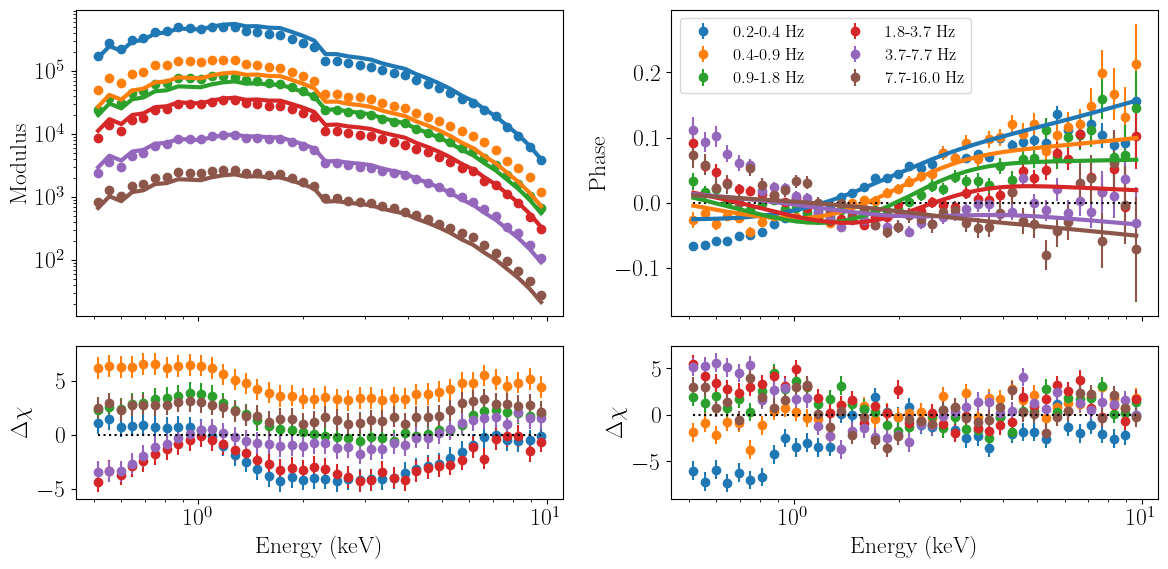

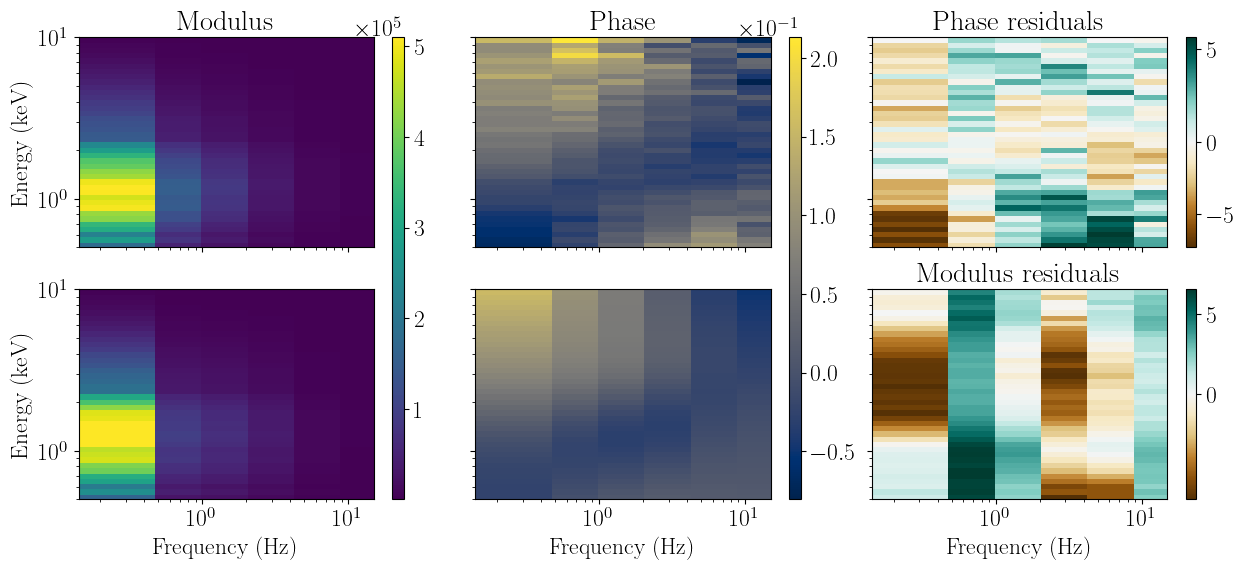

In [16]:
full_fit.fit_data()
full_fit.plot_model_1d()
full_fit.plot_model_2d()

We see once again that, without the phase re-normalization, there are strong residuals in the lag spectra at soft X-ray energies, which should not be unexpected. Additionally, while the rough energy dependence of the modulus appears fine, the normalization in each frequency bin is not. 

The reason for this model behavior is as follows. The frequency dependence of the model is set both by the model free parameters (e.g. the ones that control the pivoting behavior, like `gamma_sl` and `phi_0`), and the shape of the underlying power spectrum which drives the variability. The former are free to vary, but we have assumed that the latter is fixed and identical to a model that [fits the observed power spectrum reasonably well](https://ndspec.readthedocs.io/en/latest/fit_psd.html). The latter is an extremely strong assumption, and need not always hold.

We can get rid of this strong assumption by renormalizing each Fourier frequency bin by a (hopefully small) multiplicative constant, similarly to how the phases are renormalized if need be. This can be enabled with the `renorm_mods` method. Identically to `renorm_phases`, enabling modulus renormalization adds one free parameter per frequency bin; this time, the modulus is varied by a small multiplicative constant. 

Having enabled both phase and modulus normalization, we can run a fit again and check the results.

In [17]:
full_fit.renorm_phases(True)
full_fit.renorm_mods(True)
full_fit.print_fit_stat()
full_fit.model_params.pretty_print()

Goodness of fit metrics:
Chi squared             3288.1204163198463
Reduced chi squared     7.210790386666329
Data bins:              480
Free parameters:        24
Degrees of freedom:     456
Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
cutoff            0.3609     0.01      0.8     None    False rev_temp     None
decay_slope       -2.042      -10        0     None     True     None     None
gamma_0           0.1141        0      0.5     None     True     None     None
gamma_slope     -0.03797     -0.1        0     None     True     None     None
mods_renorm_1          1        0    1e+05     None     True     None     None
mods_renorm_2          1        0    1e+05     None     True     None     None
mods_renorm_3          1        0    1e+05     None     True     None     None
mods_renorm_4          1        0    1e+05     None     True     None     None
mods_renorm_5          1        0    1e+05     None     True     None     None
mods_renorm_6  

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1038
    # data points      = 480
    # variables        = 24
    chi-square         = 896.230679
    reduced chi-square = 1.96541816
    Akaike info crit   = 347.717630
    Bayesian info crit = 447.888497
[[Variables]]
    nH:              0.08503227 +/- 0.00803401 (9.45%) (init = 0.1152233)
    norm_pl:         3.45785853 +/- 130.615908 (3777.36%) (init = 4.560297)
    pl_index:       -1.74741839 +/- 0.02356244 (1.35%) (init = -1.799987)
    gamma_0:         0.04792348 +/- 0.00522096 (10.89%) (init = 0.1141218)
    gamma_slope:    -2.9311e-04 +/- 0.00546292 (1863.78%) (init = -0.03796799)
    phi_0:          -1.53112746 +/- 0.15438924 (10.08%) (init = -0.4175395)
    phi_slope:       2.27510895 +/- 0.14997291 (6.59%) (init = 0.4783958)
    nu_0:            0.2 (fixed)
    cutoff:          0.27890938 +/- 0.01707493 (6.12%) == 'rev_temp'
    rev_norm:        32.2198314 +/- 2431.27917 (7545.91%) (init = 18.9275

/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.
/home/matteo/Software/nDspec/src/ndspec/models.py:190: RuntimeWarning: overflow encountered in square
  model = renorm*np.power(array,3.)/planck**2
/home/matteo/Software/nDspec/src/ndspec/models.py:189: RuntimeWarning: overflow encountered in exp
  planck = np.exp(array/temp)-1.


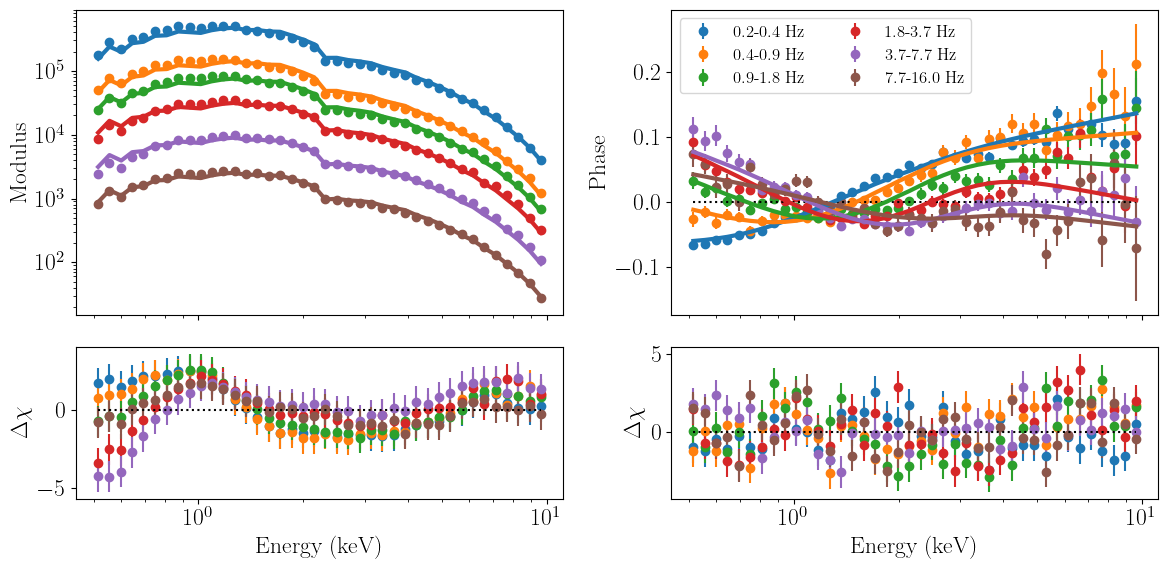

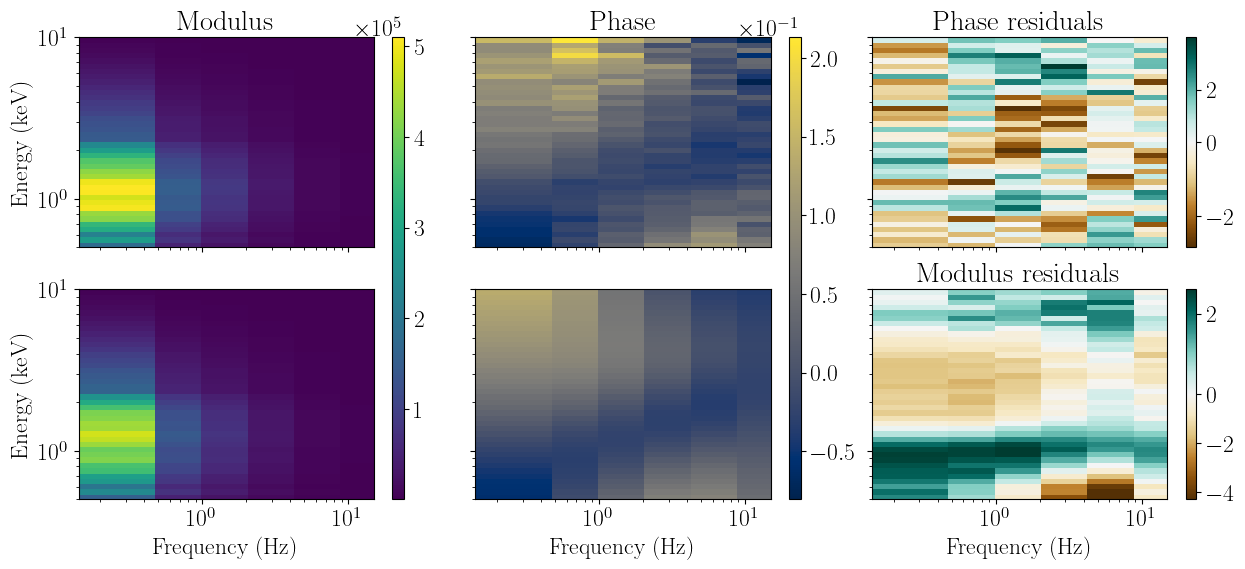

In [18]:
full_fit.fit_data()
full_fit.plot_model_1d()
full_fit.plot_model_2d()

This fit is now far better behaved. The model recovers both the shape of the lags, and the overall frequency dependence of the cross spectrum, and it does so while using fairly small renormalization parameters. 

While our model can explain very fairly well the phases, as well as the overall frequency dependence of the cross spectrum, there are significant energy-dependent residuals in the modulus. The residuals clearly show a broad structure around a few keV, reminescent of a broad line, as well as a narrower component around 1 keV. These two together are exactly what one would expect from a reflection signature. If we wanted to model the latter we would need a relativistic reverberation model like [reltrans](https://ui.adsabs.harvard.edu/abs/2021MNRAS.507...55M/abstract), which is beyond the scope of this notebook. 

Regardless, this fit highlights how the modulus of the cross spectrum carries information that might be hidden in the (lower signal:noise) phase lags.